# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/Users/rco/github/s_metaheuristic/data/log


In [2]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [3]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [4]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [5]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [6]:
@ray.remote
def import_logs(filename):
    file_path = Path(LOG_PATH, filename)
    df = pd.read_csv(file_path)
    df['filename'] = filename
    df.loc[-1:, 'last_iter'] = 1
    # df.last_iter.fillna(0, inplace=True)

    return df

ray.init(num_cpus=16)
futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH)]
dfs = ray.get(futures)

all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)


(import_logs pid=10090) 
(import_logs pid=10097) 
(import_logs pid=10086) 
(import_logs pid=10100) 
(import_logs pid=10097) 
(import_logs pid=10096) 
(import_logs pid=10086) 
(import_logs pid=10099) 
(import_logs pid=10094) 
(import_logs pid=10097) 
(import_logs pid=10088) 
(import_logs pid=10089) 
(import_logs pid=10093) 
(import_logs pid=10086) 
(import_logs pid=10095) 
(import_logs pid=10095) 
(import_logs pid=10093) 
(import_logs pid=10087) 
(import_logs pid=10089) 
(import_logs pid=10099) 
(import_logs pid=10100) 
(import_logs pid=10095) 
(import_logs pid=10091) 
(import_logs pid=10089) 
(import_logs pid=10094) 
(import_logs pid=10097) 
(import_logs pid=10100) 
(import_logs pid=10087) 
(import_logs pid=10090) 
(import_logs pid=10095) 
(import_logs pid=10091) 
(import_logs pid=10097) 
(import_logs pid=10086) 


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15729000 entries, 0 to 15728999
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   iter                int64  
 1   obj                 float64
 2   aug_obj             float64
 3   return              float64
 4   X                   object 
 5   Z                   object 
 6   max_iter            int64  
 7   neighbours          int64  
 8   alpha               float64
 9   exp_return          float64
 10  n_port              int64  
 11  k                   int64  
 12  move_strategy       object 
 13  seed                int64  
 14  selection_strategy  object 
 15  filename            object 
 16  last_iter           int64  
dtypes: float64(5), int64(7), object(5)
memory usage: 2.0+ GB


## Portfólios

### Geral

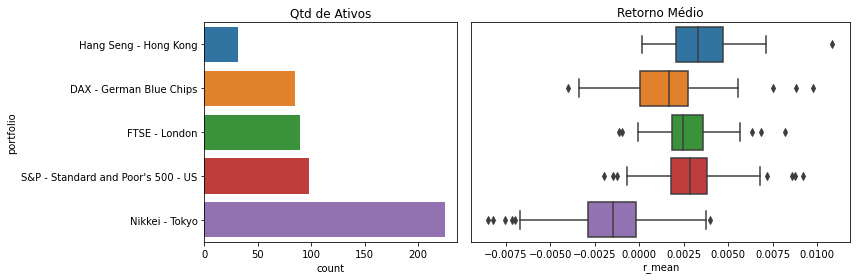

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [ ]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [ ]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

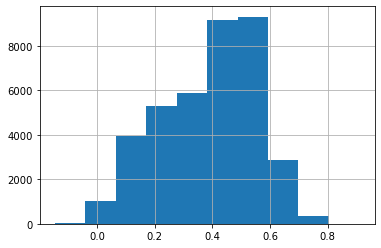

In [ ]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

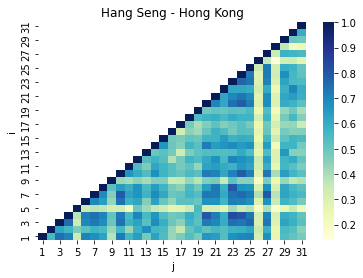

In [ ]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [ ]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


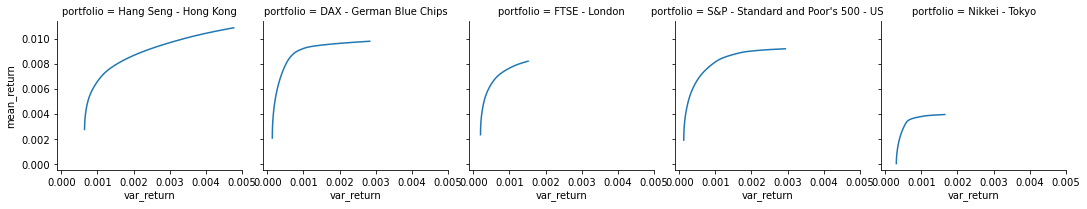

In [ ]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

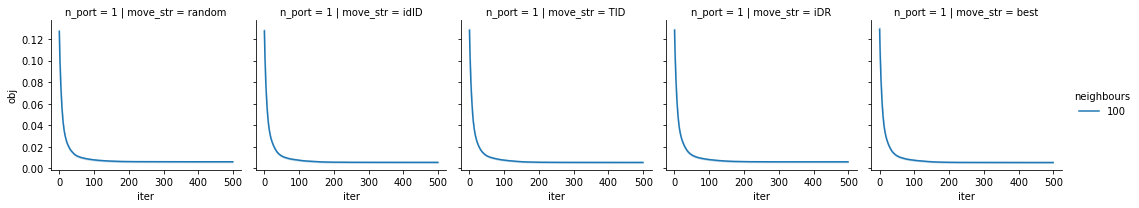

In [ ]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='n_port', hue='neighbours')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

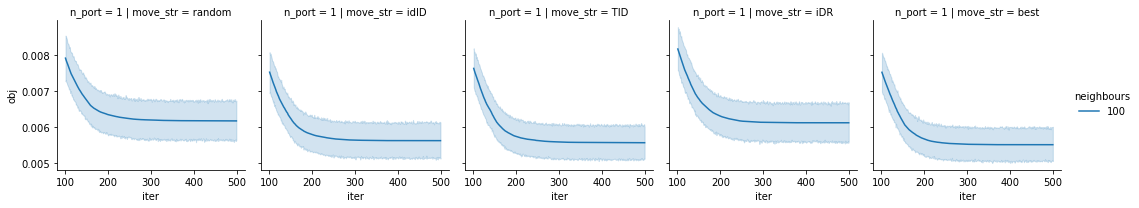

In [ ]:
g = sns.FacetGrid(
    data=all_data[all_data.iter>100], col='move_str', row='n_port', hue='neighbours')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

KeyboardInterrupt: 

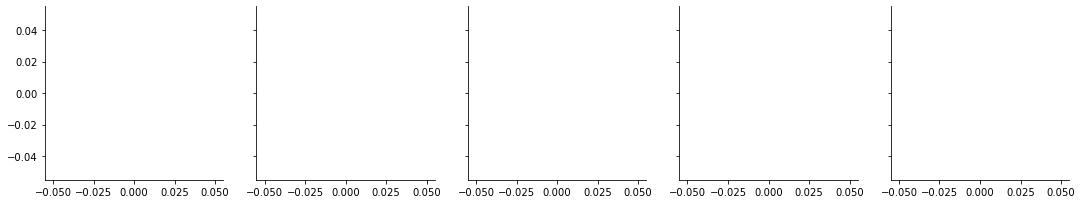

In [ ]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='n_port', hue='neighbours')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

## Análise Best - Portfólio 1

In [ ]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [ ]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(31458, 17)


,iter,obj,aug_obj,return,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,filename,Q
0,499,0.001672,0.001672,0.004763,500,100,0.3,0.0035,1,6,random,85,best,log_gls_20211117_003350_656114.csv,2.0
1,499,0.010746,0.010746,0.003501,500,100,0.1,0.0035,1,18,idID,80,random,log_gls_20211117_005107_791766.csv,3.0
2,499,0.002165,0.002165,0.001559,500,100,0.1,0.0015,1,14,idID,97,random,log_gls_20211117_030826_033448.csv,2.0
3,499,0.013722,0.013722,0.002507,500,100,0.3,0.0025,1,15,random,34,random,log_gls_20211117_021142_380734.csv,6.0
4,499,0.001233,0.001233,0.002113,500,100,0.3,0.0010,1,5,TID,6,first,log_gls_20211116_233141_589975.csv,2.0


In [ ]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,31458.0,499.000000,0.000000,499.000000,499.000000,499.000000,499.000000,499.000000
obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
aug_obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
return,31458.0,0.003893,0.002791,0.000141,0.002005,0.003186,0.004768,0.010865
max_iter,31458.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,31458.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,31458.0,0.201844,0.099985,0.100000,0.100000,0.300000,0.300000,0.300000
exp_return,31458.0,0.002845,0.002020,0.000500,0.001500,0.002500,0.003500,0.010000
n_port,31458.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
k,31458.0,9.316994,6.614256,1.000000,4.000000,8.000000,14.000000,31.000000


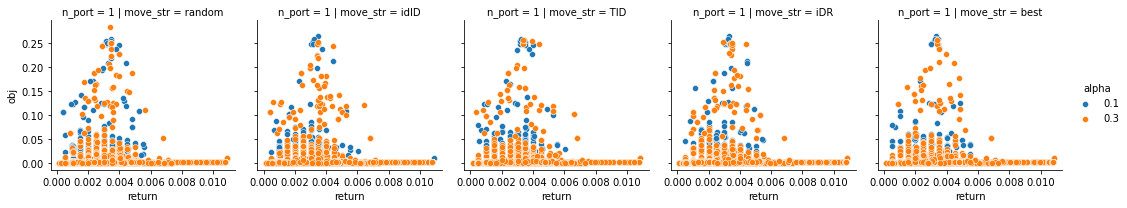

In [ ]:
g = sns.FacetGrid(data=best_data, col='move_str', row='n_port', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

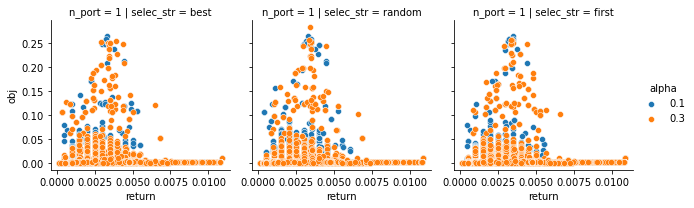

In [ ]:
g = sns.FacetGrid(data=best_data, col='selec_str', row='n_port', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

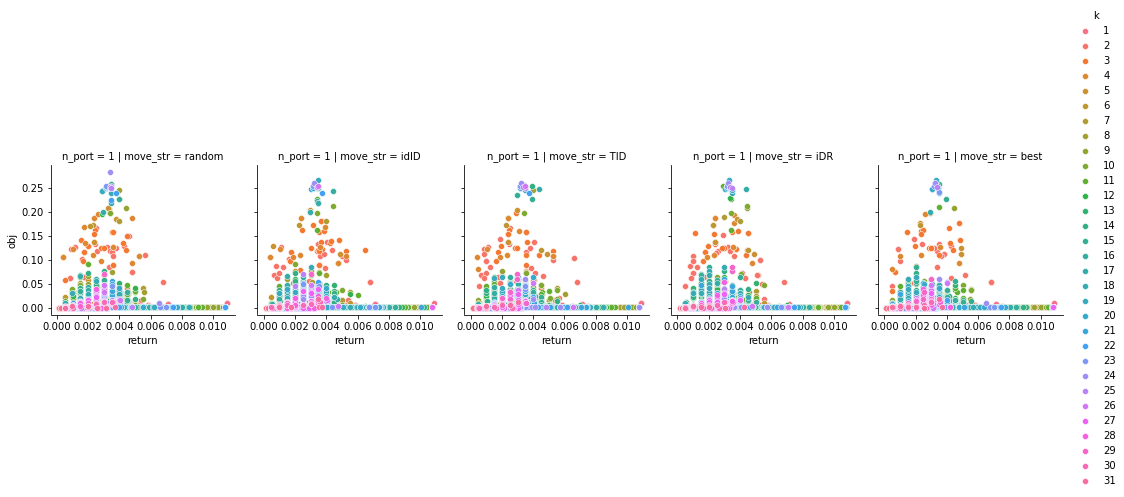

In [ ]:
g = sns.FacetGrid(data=best_data, col='move_str', row='n_port', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [ ]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,31458.0,499.000000,0.000000,499.000000,499.000000,499.000000,499.000000,499.000000
obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
aug_obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
return,31458.0,0.003893,0.002791,0.000141,0.002005,0.003186,0.004768,0.010865
max_iter,31458.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,31458.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,31458.0,0.201844,0.099985,0.100000,0.100000,0.300000,0.300000,0.300000
exp_return,31458.0,0.002845,0.002020,0.000500,0.001500,0.002500,0.003500,0.010000
n_port,31458.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
k,31458.0,9.316994,6.614256,1.000000,4.000000,8.000000,14.000000,31.000000


In [ ]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [ ]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

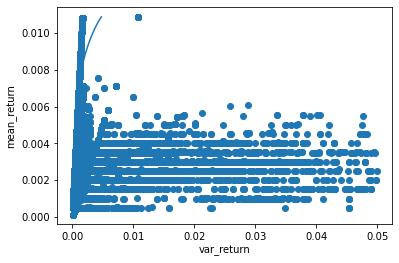

In [ ]:
data = best_data[best_data['obj']<0.05]
data = data[data.n_port==1]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [ ]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,31458.0,499.000000,0.000000,499.000000,499.000000,499.000000,499.000000,499.000000
obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
aug_obj,31458.0,0.005799,0.020366,0.000073,0.001141,0.001392,0.002389,0.283037
return,31458.0,0.003893,0.002791,0.000141,0.002005,0.003186,0.004768,0.010865
max_iter,31458.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
neighbours,31458.0,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,31458.0,0.201844,0.099985,0.100000,0.100000,0.300000,0.300000,0.300000
exp_return,31458.0,0.002845,0.002020,0.000500,0.001500,0.002500,0.003500,0.010000
n_port,31458.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
k,31458.0,9.316994,6.614256,1.000000,4.000000,8.000000,14.000000,31.000000


In [ ]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(758, 18)


In [ ]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], col='move_str', row='n_port', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

NameError: name 'sns' is not defined

Text(0, 0.5, 'mean_return')

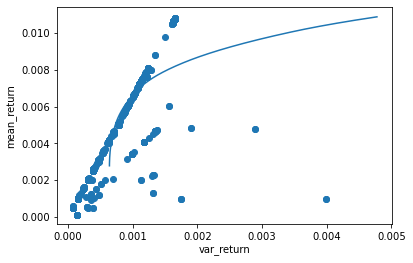

In [ ]:
port = 1
data = best_best_data[best_best_data.n_port==port]
data = data[data['obj']<0.005]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [ ]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0005  0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  \
move_str selec_str                                                           
TID      best          248     276     257     269     231     212     198   
         first         228     271     250     244     244     212     169   
         random        238     231     243     250     209     207     185   
best     best          264     239     221     237     234     219     202   
         first         233     235     253     253     268     198     215   
         random        236     210     240     268     222     212     205   
iDR      best          217     228     256     214     215     215     195   
         first         227     253     208     226     258     196     168   
         random        207     223     222     222     242     228     178   
idID     best          239     254     249     254     258     218     204   
         first         254     232     236     215     225     197     180   
         random        246     263     243     234     223     186     174   
random   best          243     231     248     235     229     218     174   
         first         231     244     241     228     232     217     182   
         random        234     243     253     251     240     223     175   

exp_return          0.0040  0.0045  0.0050  0.0055  0.0060  0.0065  0.0070  \
move_str selec_str                                                           
TID      best          136      94      58      50      24      35      33   
         first         140      83      55      44      29      40      26   
         random        127      83      49      25      37      35      35   
best     best          128      76      57      46      42      31      30   
         first         103      81      66      32      41      26      30   
         random        114      75      65      39      37      32      31   
iDR      best          116      86      65      36      27      32      28   
         first         100      85      56      42      36      42      26   
         random        130      75      49      44      40      29      23   
idID     best          129      82      53      52      34      39      33   
         first         123      86      46      47      34      26      25   
         random        122      90      58      39      29      40      37   
random   best          127      79      51      42      45      31      31   
         first         139      83      52      47      34      36      25   
         random        126      87      55      43      35      40      21   

exp_return          0.0075  0.0080  0.0085  0.0090  0.0095  0.0100  
move_str selec_str                                                  
TID      best           31      16      13      15      16      15  
         first          22      23      17      19      12      12  
         random         17      19      14      11      12      17  
best     best           24      14      17      21      15      11  
         first          38      15      19       9      21      19  
         random         25      13      22      15      18      16  
iDR      best           24      15      14      12      20      10  
         first          24      18      18      21      19      15  
         random         18      14      25      11      15      11  
idID     best           20      22      14      11      15      13  
         first          28      21      12      13      10      16  
         random         23      18      18      15      14      11  
random   best           28      17      17      14      15      12  
         first          19      16      15      18      19      10  
         random         20      17      14      17      14      15

In [ ]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0005    0.0010    0.0015    0.0020    0.0025  \
move_str selec_str                                                     
TID      best       0.000073  0.000154  0.000229  0.000282  0.000141   
         first      0.000074  0.000141  0.000229  0.000141  0.000387   
         random     0.000074  0.000153  0.000231  0.000282  0.000282   
best     best       0.000073  0.000150  0.000141  0.000312  0.000141   
         first      0.000073  0.000141  0.000228  0.000306  0.000282   
         random     0.000074  0.000150  0.000141  0.000282  0.000282   
iDR      best       0.000073  0.000150  0.000141  0.000305  0.000282   
         first      0.000073  0.000141  0.000229  0.000282  0.000282   
         random     0.000076  0.000151  0.000231  0.000141  0.000383   
idID     best       0.000076  0.000141  0.000228  0.000282  0.000141   
         first      0.000074  0.000141  0.000227  0.000141  0.000141   
         random     0.000073  0.000151  0.000228  0.000141  0.000282   
random   best       0.000076  0.000150  0.000141  0.000282  0.000389   
         first      0.000073  0.000141  0.000230  0.000305  0.000282   
         random     0.000074  0.000150  0.000228  0.000282  0.000382   

exp_return            0.0030    0.0035    0.0040    0.0045    0.0050  \
move_str selec_str                                                     
TID      best       0.000141  0.000541  0.000282  0.000282  0.000840   
         first      0.000141  0.000282  0.000282  0.000282  0.000141   
         random     0.000458  0.000551  0.000282  0.000141  0.000282   
best     best       0.000141  0.000141  0.000392  0.000141  0.000141   
         first      0.000141  0.000546  0.000282  0.000141  0.000777   
         random     0.000141  0.000536  0.000141  0.000282  0.000392   
iDR      best       0.000392  0.000141  0.000141  0.000141  0.000282   
         first      0.000392  0.000282  0.000141  0.000141  0.000282   
         random     0.000141  0.000282  0.000141  0.000282  0.000775   
idID     best       0.000282  0.000282  0.000282  0.000392  0.000141   
         first      0.000282  0.000282  0.000282  0.000282  0.000282   
         random     0.000282  0.000141  0.000282  0.000141  0.000282   
random   best       0.000141  0.000282  0.000618  0.000282  0.000797   
         first      0.000282  0.000141  0.000282  0.000392  0.000141   
         random     0.000458  0.000282  0.000141  0.000141  0.000141   

exp_return            0.0055    0.0060    0.0065    0.0070    0.0075  \
move_str selec_str                                                     
TID      best       0.000282  0.000930  0.000282  0.000282  0.000141   
         first      0.000141  0.000141  0.000141  0.000282  0.000392   
         random     0.000282  0.000282  0.000141  0.000141  0.000282   
best     best       0.000392  0.000923  0.000999  0.000282  0.000282   
         first      0.000141  0.000141  0.000141  0.000141  0.001189   
         random     0.000282  0.000282  0.000141  0.000282  0.000282   
iDR      best       0.000141  0.000282  0.000141  0.000141  0.000141   
         first      0.000141  0.000141  0.000141  0.000392  0.000141   
         random     0.000853  0.000282  0.001011  0.001130  0.001169   
idID     best       0.000282  0.000141  0.000141  0.001100  0.000141   
         first      0.000141  0.000282  0.000141  0.000141  0.000141   
         random     0.000392  0.000282  0.000141  0.000282  0.000141   
random   best       0.000141  0.000282  0.001001  0.000282  0.000282   
         first      0.000141  0.000141  0.000282  0.000392  0.000141   
         random     0.000282  0.000141  0.000282  0.000141  0.000282   

exp_return            0.0080    0.0085    0.0090    0.0095    0.0100  
move_str selec_str                                                    
TID      best       0.000282  0.000282  0.000141  0.000141  0.001309  
         first      0.001487  0.000392  0.000141  0.001648  0.000392  
         random     0.000282  0.000141  0

In [ ]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(20, 2)


,exp_return,obj
0,0.0005,0.000073
1,0.0010,0.000141
2,0.0015,0.000141
3,0.0020,0.000141
4,0.0025,0.000141


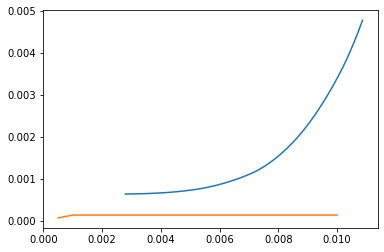

In [ ]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)